# Notebook for Dog Classifier

In [23]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [24]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [25]:
key = os.environ.get('AZURE_SEARCH_KEY', '<KEY>')

In [26]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [27]:
results = search_images_bing(key, 'german shepherd dogs')
ims = results.attrgot('content_url')
len(ims)

150

In [28]:
ims[1]

'https://www.perropet.com/wp-content/uploads/2016/05/Buck_The_GSD.jpg'

In [29]:
dest = 'images/example.jpg'
download_url(ims[1], dest)

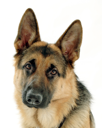

In [30]:
im = Image.open(dest)
im.to_thumb(128,128)

In [31]:
dog_types = ['german shepherd', 'black', 'labrador']
path = Path('dogs')


In [32]:
if not path.exists():
    path.mkdir()
    for t in dog_types:
        dest = (path/t)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, '{} dog'.format(t))
        download_images(dest, urls=results.attrgot('content_url'))
    

In [33]:
fns= get_image_files(path)
fns


(#382) [Path('dogs/german shepherd_fixed.jpg'),Path('dogs/black_fixed.jpg'),Path('dogs/labrador_fixed.jpg'),Path('dogs/german shepherd/00000107.jpg'),Path('dogs/german shepherd/00000034.jpg'),Path('dogs/german shepherd/00000091.jpg'),Path('dogs/german shepherd/00000135.jpg'),Path('dogs/german shepherd/00000126.jpg'),Path('dogs/german shepherd/00000023.jpg'),Path('dogs/german shepherd/00000012.jpg')...]

In [34]:
##finding out the no. of failed images
failed = verify_images(fns)
failed

(#0) []

In [35]:
##removing all the failed images using unlink
failed.map(Path.unlink);

In [36]:
##
dogs = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=41),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [37]:
dls = dogs.dataloaders(path)

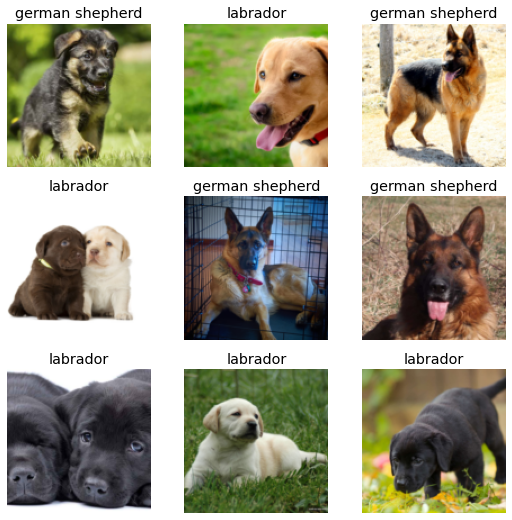

In [38]:
dls.valid.show_batch()

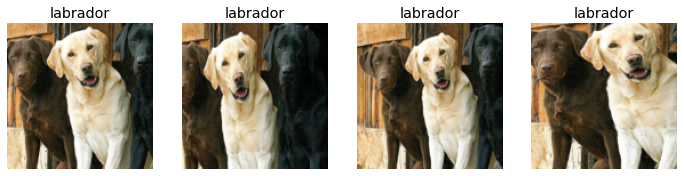

In [39]:
##adding item transformations
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation


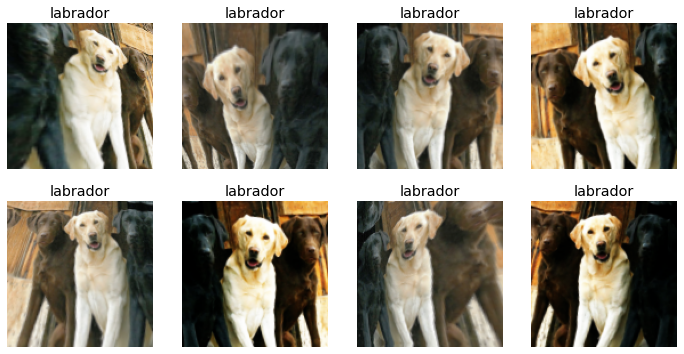

In [40]:
##adding item transformations
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the Model

In [41]:
dogs = dogs.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
               batch_tfms=aug_transforms())

dls = dogs.dataloaders(path)

In [42]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.832697,0.509845,0.197368,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.718267,0.380108,0.144737,00:04
1,0.598219,0.223160,0.092105,00:05
2,0.461343,0.192993,0.065789,00:05
3,0.407174,0.179750,0.065789,00:04


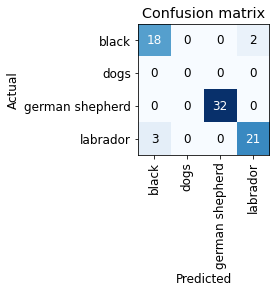

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

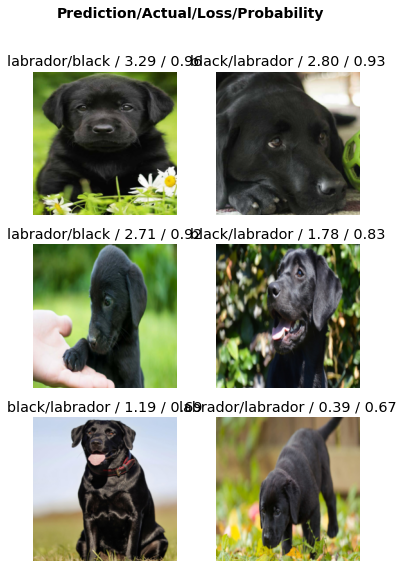

In [44]:
interp.plot_top_losses(6, nrows=3)

## Cleaning the Data

In [45]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [46]:
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), str(path/cat).split('.')[0] + "_fixed.jpg")

In [47]:
learn.export()

In [48]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [49]:
learn_inf = load_learner(path/'export.pkl')

In [50]:
learn_inf.predict('dogs/labrador/00000000.jpg')

('labrador',
 tensor(3),
 tensor([1.3822e-04, 2.7107e-03, 1.0373e-04, 9.9705e-01]))

In [51]:
learn_inf.dls.vocab

(#4) ['black','dogs','german shepherd','labrador']

In [57]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [58]:
VBox([widgets.Label('Select your dog!'),
      btn_upload, btn_run, out_pl, lbl_pred])